# Question 1. Moore's Law

## (a) Extract data and produce a semi-log plot

The benchmark I choose is `cpu95`. There are N=9372 instances for this benchmark. The $y$ values are the log_2 of the base speeds. Of all the dates recorded for this benchmark, 1996-01-31 is the earliest. All the dates are converted to days after this earliest date. 

Earliest data is: 1996-01-31


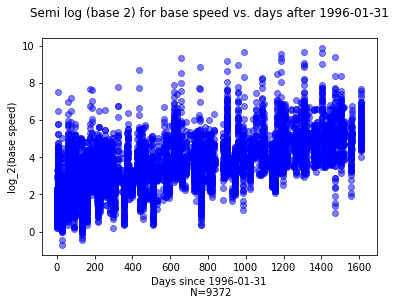

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
import numpy as np
import datetime as dt
from scipy import stats

file = open('./specdata20120207/benchmarks.txt', 'r') 
i = 0
dates = []
bases = []
for line in file:
    if i==0:  # skip the header
        i += 1
        continue
    testID = line.split(',')[0]
    if not testID.startswith('cpu95'): # only consider benchmark cpu95
        continue
    mask_date = testID.split('-')[1]
    date = ''
    if mask_date.startswith('9'):  # convert, eg, 98 to 1998
        date += '19' + mask_date[:2] + '-' + mask_date[2:4] + '-' + mask_date[4:]
    else:
        date += mask_date[:4] + '-' + mask_date[4:6] + '-' + mask_date[6:]
    dates.append(date)
    bases.append(float(line.split(',')[-2]))
    i += 1
dates = [pd.to_datetime(d) for d in dates]
min_date = min(dates)
print('Earliest data is:', str(min_date).split(' ')[0])
dates = np.array(dates)-min_date
dates = [float(str(timedelta).split(' ')[0]) for timedelta in dates]
bases = [[base] for base in bases]
bases = np.log2(bases)
# plt.semilogy(dates, bases, 'bo', alpha = 0.5)
plt.plot(dates, bases, 'bo', alpha = 0.5)
plt.xlabel('Days since 1996-01-31\n N={}'.format(len(dates)))
plt.ylabel('log_2(base speed)')
plt.title('Semi log (base 2) for base speed vs. days after 1996-01-31\n') 
plt.show()


## (b) Train a linear model to fit your plot.

According to Moore's law, the base speed $s$ is expected to double every two years, or every $365.25\times 2=730.5$ days. That means, the Moore's law states that the true relationship between time and base speed is:
$$s=S_0\times 2^{t/730.5}$$
with $S_0$ being the speed at the initial time $t=0$ and $t$ is measured in days.
Taking the logarithm base 2 of both sides of the above equation gets us:
$$log_2(s)=log_2(S_0\times2^{t/730.5})=log_2(S_0)+\frac{1}{730.5}t$$
It follows that Moore's law concludes a linear model of the relationship between $log_2(s)$ and $t$. For this reason, checking how well Moore's law holds up is checking whether the relationship between $log_2(s)$ and $t$ follows a linear model. The goal here is to examine the relationship between the predictor $t$ and the response $log_2(s)$, so the interpretive power of the model is of interest. That is why we will use a regression model because such a model is, although not flexible as other models, has good interpretability. Had the prediction accuracy been of primary concern, we would have chosen fancier classification models.

Coefficients: 
 [[0.00180707]]
Intercept:
 [2.36785956]
Mean squared error: 1.12


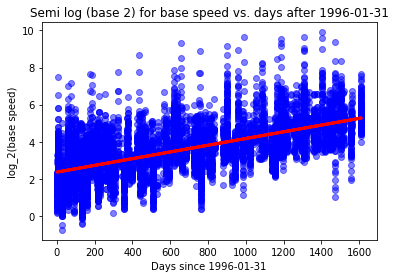

In [2]:

# dates_num = pd.to_datetime(dates)
# dates_num = dates_num.map(dt.datetime.toordinal)
# dates_num = [[num] for num in dates_num]
# Create linear regression object
dates = [[date] for date in dates] 
regr = linear_model.LinearRegression()

# Train the model using the training sets
# regr.fit(dates_num, bases)
regr.fit(dates, bases)

# Make predictions using the testing set
# base_preds = regr.predict(dates_num)
base_preds = regr.predict(dates)

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept:\n', regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(bases, base_preds))

# Plot outputs
# plt.scatter(dates_num, bases,  color='blue', alpha=0.5)
# plt.plot(dates_num,base_preds, color='red', linewidth=3)
plt.scatter(dates, bases,  color='blue', alpha=0.5)
plt.plot(dates,base_preds, color='red', linewidth=3)
plt.xlabel('Days since 1996-01-31')
plt.ylabel('log_2(base speed)')
plt.title('Semi log (base 2) for base speed vs. days after 1996-01-31')
# plt.xticks(())
# plt.yticks(())

plt.show()

The stats printed above mean that, if we assume a linear relationship between $log_2(s)$ and $t$ ($log_2(s)=log_2(S_0)+S_1t$), then the estimates for $log_2(S_0)$ and $S_1$ are:
$$\hat{log_2(S_0)}=2.36785956$$
$$\hat{S_1}=0.00180707$$
The true value of $S_1$, according to Moore's law, is $\frac{1}{730.5}=0.001368925$. We see that there is a slight difference between the estimate and the claimed true value. So how can we conclude whether the Moore's law is correct? Let us construct the 95% confidence interval for the slope $\hat{S_1}$. 

According to ISLR (p.66), the formula for the standard error of the coefficient is:
$$SE(\hat{S_1})^2=\frac{\sigma ^2}{\sum_{i=1}^{n}(x_i-\overline{x})^2 }=\frac{RSS/(n-2)}{\sum_{i=1}^{n}(x_i-\overline{x})^2}$$
where RSS is the residual sum of squares.

In [3]:
n = len(dates)
RSS = np.sum((dates - regr.predict(dates))**2)
mean_x = np.sum(dates)/len(dates)
SE = (RSS/(n-2))/ np.sum((dates-mean_x)**2)
upper = regr.coef_ + 2*SE
lower = regr.coef_ - 2*SE
print('upper:', upper)
print('lower:', lower)

upper: [[0.00244528]]
lower: [[0.00116886]]


The 95% confidence interval is $[0.00116886, 0.00244528]$. This means that if we construct such an interval repeatedly, 95% of the time the intervals will capture the true coefficient. Because 0.001368925 (1/730.5) lies in the interval we've just constructed, we are confident the Moore's law does hold up.  (**applying** **#confidenceinterval**)

# Question 2. MNIST

## (a) Load the data and plot some examples

(1797, 64)


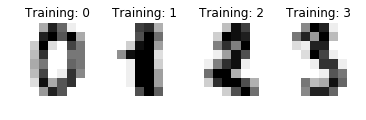

In [4]:
digits = sklearn.datasets.load_digits()
print(digits.data.shape)
# image showing code from https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)


## (b) Choose two digit classes (e.g 7s and 3s) , and train a k-nearest neighbor classifier.

In this section we will choose 5 and 6 as the two classes. We will follow the KNN algorithm specified in Barber (2012). That means in the `sklearn.neighbors.KNeighborsClassifier` instantiation, `weights` is set to `'uniform'`, as the algorithm in Barber (2012) assigns equal weights to the $k$ neighbors. There are several things to decide about the KNN:
1. The number of neighbors $k$
2. The dissimilarity function. We will investigate two metrics: L1 and L2 distances. L1 distance is the sum of the pixel-wise absolute differences, while L2 is the vanilla Euclidean distance (sum of squared differences). To do this, we set the argument `metric=minkowski`, which calculates the distances according to the formula `sum(|x - y|^p)^(1/p)`. If we the further set `p=1`, it is the L1 distance; if `p=2`, it is the L2 distance. 

To tune $k$ and decide on the dissimilarity function, we will use cross validation (leave one out). Leave one out is chosen over k-fold because we have little data (~360), and only part of it is training data. If we make a fixed validation set, then the training data is further shrunken. 

Data size: 363

Plotting some examples ...


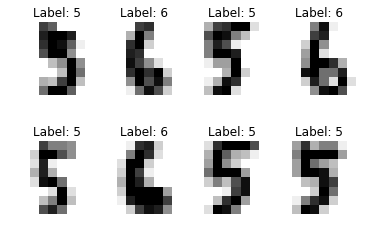

In [16]:
# get 5's and 6's
def get_data(X, y, digit_list):
    mask = []
    for label in y:
        to_append = False
        for digit in digit_list:
            if label == digit:
                to_append = True
        mask.append(to_append)
    return X[mask,:,:], y[mask]

X, y = get_data(digits.images,digits.target, [5,6])                
print('Data size:', len(X))

# plotting some examples
print('\nPlotting some examples ...')
images_and_labels = list(zip(X,y))
for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Label: %i' % label)

In [8]:
import pandas as pd
from sklearn import datasets, linear_model
# source: https://machinelearningmastery.com/evaluate-performance-machine-learning-algorithms-python-using-resampling/
# source: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-i-i-d-data

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.33)
X_train = np.reshape(X_train, (X_train.shape[0],-1))
X_test = np.reshape(X_test, (X_test.shape[0],-1))
print('Shape of training features:', X_train.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of testing features:', X_test.shape)
print('Shape of testing labels:', y_test.shape)
def run_knn_selection(X_train, y_train, cv_type='loo', verbose=False):
    i = 0
    max_k = 10
    best_accuracy = -1
    best_params = {'k': -1, 'p': -1 }
    print('Running ...')
    for k in range(1, max_k+1):
        for p in [1,2]:
            clf = neighbors.KNeighborsClassifier(n_neighbors=k, 
                                                 weights='uniform',
                                                 p=p, 
                                                 metric='minkowski')
            cv = model_selection.LeaveOneOut()
            scores = model_selection.cross_val_score(clf, X_train, y_train, cv=cv)
            if np.mean(scores) > best_accuracy:
                best_accuracy = np.mean(scores)
                best_params['k'], best_params['p'] = k, p
            i += 1
            if verbose:
                if i%5==0:
                    print('Finished %d/%d'%(i,max_k*2))
    print('Best k:', best_params['k'])
    print('Best distance type:', best_params['p'])
    print('Val Accuracy:', best_accuracy)
    return best_params, best_accuracy
best_params, best_accuracy = run_knn_selection(X_train, y_train, verbose=True)

Shape of training features: (243, 64)
Shape of training labels: (243,)
Shape of testing features: (120, 64)
Shape of testing labels: (120,)
Running ...
Finished 5/20
Finished 10/20
Finished 15/20
Finished 20/20
Best k: 8
Best distance type: 1
Val Accuracy: 1.0


The results show that the optimal $k$ is 8 with L1 distance used. We will train the data using these parameters:

In [9]:
best_k, best_p = best_params.values()
clf = neighbors.KNeighborsClassifier(n_neighbors=best_k, 
                                     weights='uniform',
                                     p=best_p,
                                     metric='minkowski')
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=1,
           weights='uniform')

## (c) Report your error rates on a held out part of the data.

In [10]:
test_acc = clf.score(X_test, y_test)
print('Test accuracy:', test_acc)

Test accuracy: 0.9916666666666667


## (d) Train for 10 classes on the full data set

Loading the data: 

In [23]:
# ! pip install python-mnist
from mnist import MNIST

mndata = MNIST('samples')
X_train, y_train = mndata.load_training()

X_test, y_test = mndata.load_testing()

As the dataset is large, we can designate a fixed part of the training data set as the validation set (no need for cross-validation). 

In [24]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, 
                                                                  y_train, 
                                                                  test_size=.33)

print('Shape of training features:', X_train.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of val features:', X_val.shape)
print('Shape of val labels:', y_val.shape)
print('Shape of testing features:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

Shape of training features: (40200, 784)
Shape of training labels: (40200,)
Shape of val features: (19800, 784)
Shape of val labels: (19800,)
Shape of testing features: (10000, 784)
Shape of testing labels: (10000,)


I found that training using the library is extremely time-consuming, while this should not be the case: all the KNN does in the training phase is memorizing data and the distances between each of the testing/validating point to all the training data points should be computed only once. I coded the KNN from scratch below (adapted from Assignment 1 of [CS1231n](http://cs231n.github.io/assignments2017/assignment1/)) and the implementation was feasible. 

In [27]:
class KNearestNeighbor(object):
  """ a kNN classifier with Eucledian distance """
  def __init__(self):
    pass

  def train(self, X, y):
    self.X_train = X
    self.y_train = y

  def compute_distances(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    dists = np.sqrt((np.sum(X**2, axis=1)).reshape(num_test,1) + np.sum(self.X_train**2, axis=1) - 2*np.dot(X,np.transpose(self.X_train)))
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point. 
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i,:])[0:k]]
      y_pred[i] = stats.mode(closest_y)[0]
    return y_pred

In [28]:
# training
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances(X_val)

We assumed the L2 distance metric and only tune the parameter $k$.

In [30]:
best_acc = -1
i = 0
for k in range(1,11):
    y_val_pred = classifier.predict_labels(dists, k=k)
    # Compute val accuracy
    num_correct = np.sum(y_val_pred == y_val)
    accuracy = float(num_correct) / len(y_val)
    if accuracy > best_acc:
        best_acc = accuracy
        best_k = k
    i += 1
    print('Finished %d/10'%i)
print('-'*50)
print('Optimal k is:', best_k)

Finished 1/10
Finished 2/10
Finished 3/10
Finished 4/10
Finished 5/10
Finished 6/10
Finished 7/10
Finished 8/10
Finished 9/10
Finished 10/10
--------------------------------------------------
Optimal k is: 1


In [31]:
# testing
dists = classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=best_k)
# Compute test accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test)
print('Testing accuracy:', accuracy)

Testing accuracy: 0.9661
